In [1]:
from thompson_bandit import ThompsonSamplingBandit
from sklearn.preprocessing import StandardScaler
from pathlib import Path

import json
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
cfg = json.loads(Path("config.json").read_text())

pprint(cfg)

df = pd.read_csv(cfg["csv"])
# We assume that the dataset has been rescaled before, and
# we are just transforming it using a previously fit scaler
scaler = StandardScaler()
df[cfg["context_cols"]] = scaler.fit_transform(df[cfg["context_cols"]])

results = {}

bandit = ThompsonSamplingBandit(
    arms = cfg["arms"],
    context_context_cols = cfg["context_cols"],
    min_ppp = cfg["min_ppp"],
    points_per_txn = cfg["points_per_txn"],
    min_obs = cfg["min_obs"],
    init_alpha = 1,
    init_beta = 1,
    ppp_margin = cfg["ppp_margin"],
    refit_every = 1
)

{'arms': [0.4, 0.45, 0.5],
 'context_cols': ['FLAG_FIRST_TIME_VISITOR',
                  'FLAG_FIRST_TIME_BUYER',
                  'CURRENT_BALANCE',
                  'DAYS_SINCE_LAST_PURCHASE_L12M',
                  'COUNT_TRANX_L12M',
                  'DAYS_SINCE_LAST_VISIT_NO_PURCHASE',
                  'LAST_OFFER_RICHNESS_SERVED_ON_PURCHASE_L12M',
                  'OFFER_RICHNESS_APPLIED_ON_LAST_PURCHASE_L12M',
                  'POINTS_PURCHASED_LAST_TRANX_L12M'],
 'csv': 'DATA_MULTI_ARM_BANDIT.csv',
 'min_obs': 20,
 'min_ppp': 0.016,
 'out_dir': 'output',
 'points_per_txn': 3000,
 'ppp_margin': 0.0001}


## Monte-Carlo Simulation

In [4]:
# This will take about 25 minutes to run

oversampled_contextual_bandit = []
for n in range(50):
    revenue_curve, _, _, _, _, _ = bandit.oversampled_contextual_bandit(df.copy())
    oversampled_contextual_bandit.append(revenue_curve[-1])

    
contextual_bandit = []
for n in range(50):
    revenue_curve, _, _, _, _, _ = bandit.contextual_bandit(df.copy())
    contextual_bandit.append(revenue_curve[-1])
    
perfect_bandit = []
for n in range(50):
    revenue_curve, _, _, _, _, _ = bandit.perfect_bandit(df.copy())
    perfect_bandit.append(revenue_curve[-1])
    
basic_bandit = []
for n in range(50):
    revenue_curve, _, _, _, _, _ = bandit.basic_bandit(df.copy())
    basic_bandit.append(revenue_curve[-1])

SMOTE Contextual TS: mean = 11724.600, std = 2621.088
Contextual TS: mean = 9758.730, std = 1910.484
Perfect TS: mean = 20739.540, std = 5567.367
Basic TS: mean = 10332.480, std = 2293.303


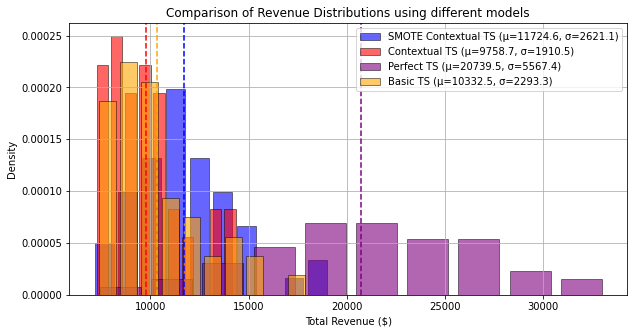

In [5]:
# Calculate statistics
mean1, std1 = np.mean(oversampled_contextual_bandit), np.std(oversampled_contextual_bandit)
mean2, std2 = np.mean(contextual_bandit), np.std(contextual_bandit)
mean3, std3 = np.mean(perfect_bandit), np.std(perfect_bandit)
mean4, std4 = np.mean(basic_bandit), np.std(basic_bandit)

# Print statistics
print("SMOTE Contextual TS: mean = {:.3f}, std = {:.3f}".format(mean1, std1))
print("Contextual TS: mean = {:.3f}, std = {:.3f}".format(mean2, std2))
print("Perfect TS: mean = {:.3f}, std = {:.3f}".format(mean3, std3))
print("Basic TS: mean = {:.3f}, std = {:.3f}".format(mean4, std4))

# Plot the distributions
plt.figure(figsize=(10, 5))
plt.hist(oversampled_contextual_bandit, 
         bins=10, 
         alpha=0.6, 
         color='blue', 
         density=True,
         rwidth=0.8,
         linewidth=0.8,
         edgecolor='black',
         label='SMOTE Contextual TS (μ={:.1f}, σ={:.1f})'.format(mean1, std1))
plt.hist(contextual_bandit, 
         bins=10, 
         alpha=0.6, 
         color='red', 
         density=True,
         rwidth=0.8,
         linewidth=0.8,
         edgecolor='black',
         label='Contextual TS (μ={:.1f}, σ={:.1f})'.format(mean2, std2))
plt.hist(perfect_bandit, 
         bins=10, 
         alpha=0.6, 
         color='purple', 
         density=True,
         rwidth=0.8,
         linewidth=0.8,
         edgecolor='black',
         label='Perfect TS (μ={:.1f}, σ={:.1f})'.format(mean3, std3))
plt.hist(basic_bandit, 
         bins=10, 
         alpha=0.6, 
         color='orange', 
         density=True,
         rwidth=0.8,
         linewidth=0.8,
         edgecolor='black',
         label='Basic TS (μ={:.1f}, σ={:.1f})'.format(mean4, std4))

# Plot means as vertical lines
plt.axvline(mean1, color='blue', linestyle='--')
plt.axvline(mean2, color='red', linestyle='--')
plt.axvline(mean3, color='purple', linestyle='--')
plt.axvline(mean4, color='orange', linestyle='--')

# Add labels and legend
plt.title("Comparison of Revenue Distributions using different models")
plt.xlabel("Total Revenue ($)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.savefig("monte_carlo_simulation.png")
plt.show()